In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/clear_cloudy_merged/train_B_over"
plot_title = "train_B_over"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.798912,0.805319,0.773867,0.805319,0.759725,0.939294,0.936736,0.896630,0.871761,0.685264
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.839365,0.841947,0.822044,0.841947,0.810262,0.954738,0.950252,0.918150,0.900379,0.744456
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.853985,0.855996,0.839767,0.855996,0.828334,0.959856,0.955609,0.927064,0.912627,0.767383
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.868775,0.870045,0.857279,0.870045,0.848080,0.964480,0.960537,0.936734,0.922185,0.790353
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.880527,0.881586,0.869363,0.881586,0.861130,0.967358,0.963432,0.941947,0.928935,0.809141


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.869660,0.8670,0.692627,0.8670,0.706919,0.958269,0.901315,0.929723,0.760709,0.564426
1,2,test,0.880814,0.8750,0.731739,0.8750,0.774007,0.961071,0.925959,0.933834,0.812112,0.617856
2,3,test,0.887159,0.8810,0.750486,0.8810,0.802851,0.964570,0.932336,0.938897,0.828646,0.644172
3,4,test,0.876435,0.8665,0.738663,0.8665,0.818762,0.960393,0.935368,0.931396,0.832650,0.630688
4,5,test,0.882400,0.8740,0.748049,0.8740,0.818478,0.964401,0.938346,0.937719,0.840940,0.641311


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/403:,Train,Loss,=,1.523,Valid,Loss,=,1.525,ETA,=,6.20h
1,Epoch,"1/40,",Batch,20/403:,Train,Loss,=,1.475,Valid,Loss,=,1.482,ETA,=,5.86h
2,Epoch,"1/40,",Batch,30/403:,Train,Loss,=,1.466,Valid,Loss,=,1.451,ETA,=,5.08h
3,Epoch,"1/40,",Batch,40/403:,Train,Loss,=,1.454,Valid,Loss,=,1.395,ETA,=,5.20h
4,Epoch,"1/40,",Batch,50/403:,Train,Loss,=,1.398,Valid,Loss,=,1.375,ETA,=,5.09h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.523,1.525
20,1,20,1.475,1.482
30,1,30,1.466,1.451
40,1,40,1.454,1.395
50,1,50,1.398,1.375


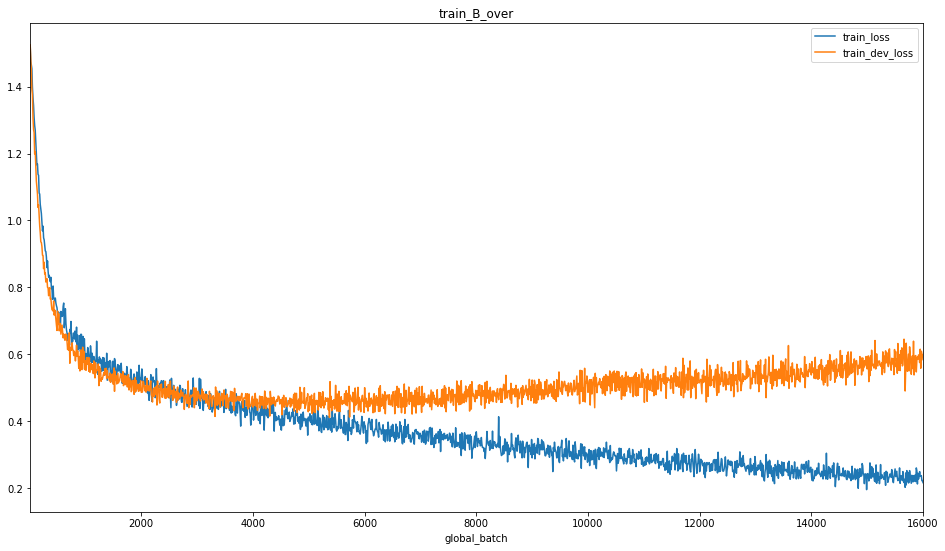

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,1.0270,0.9350
2,0.7055,0.6600
3,0.6055,0.5730
4,0.5675,0.5335
5,0.5265,0.5170


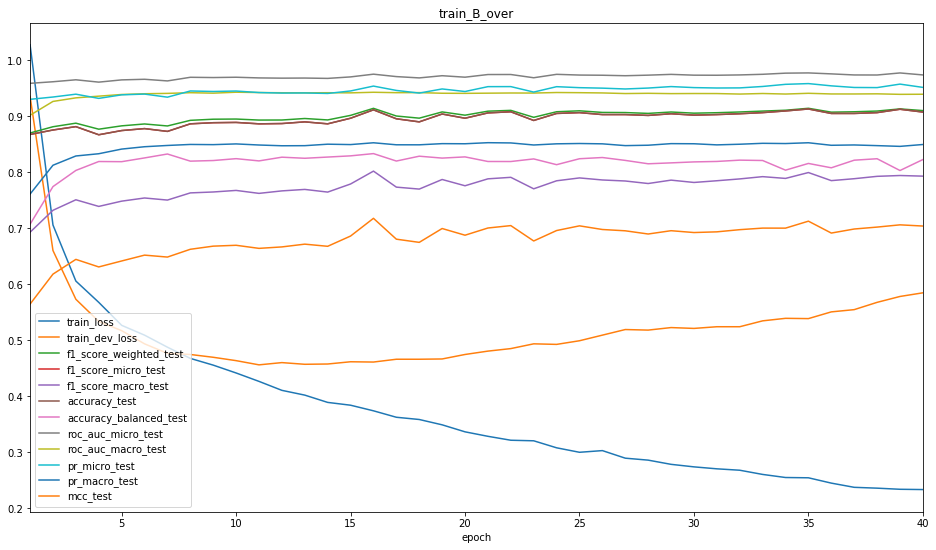

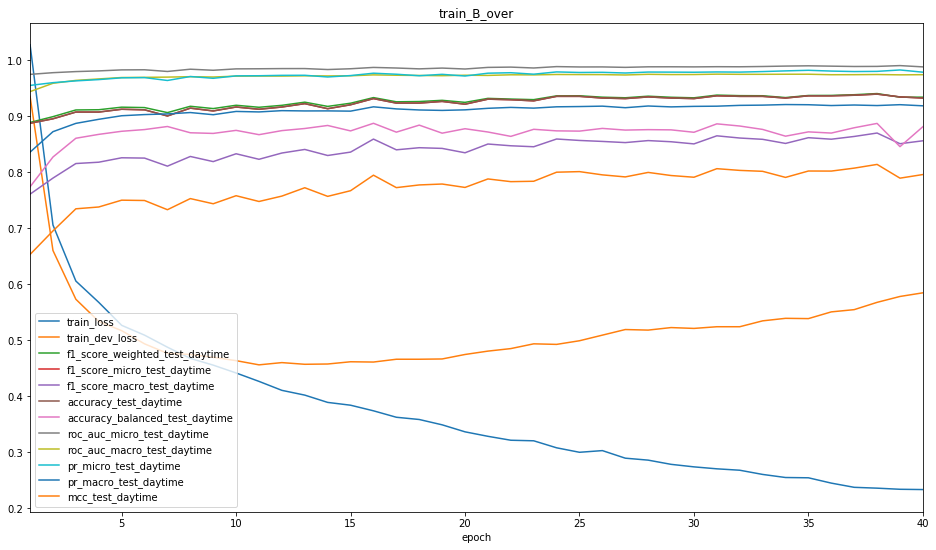

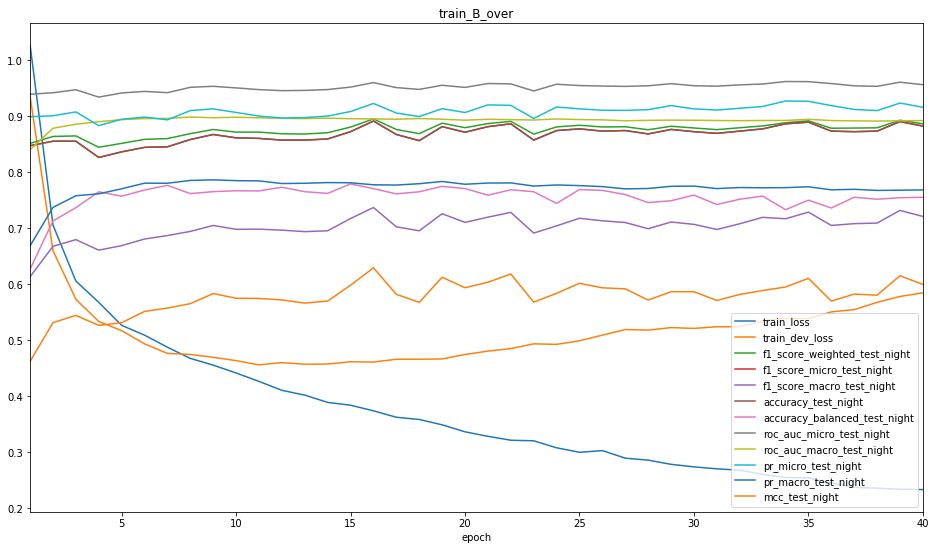

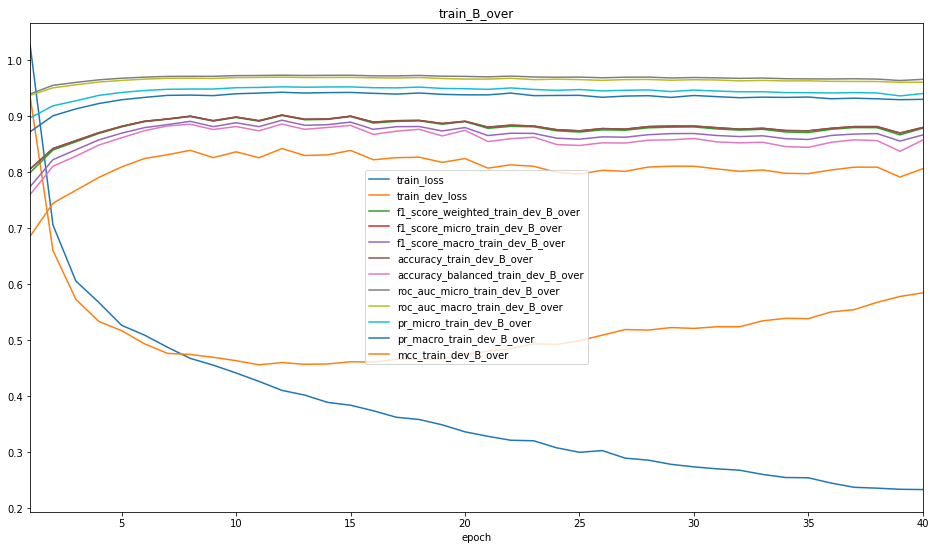

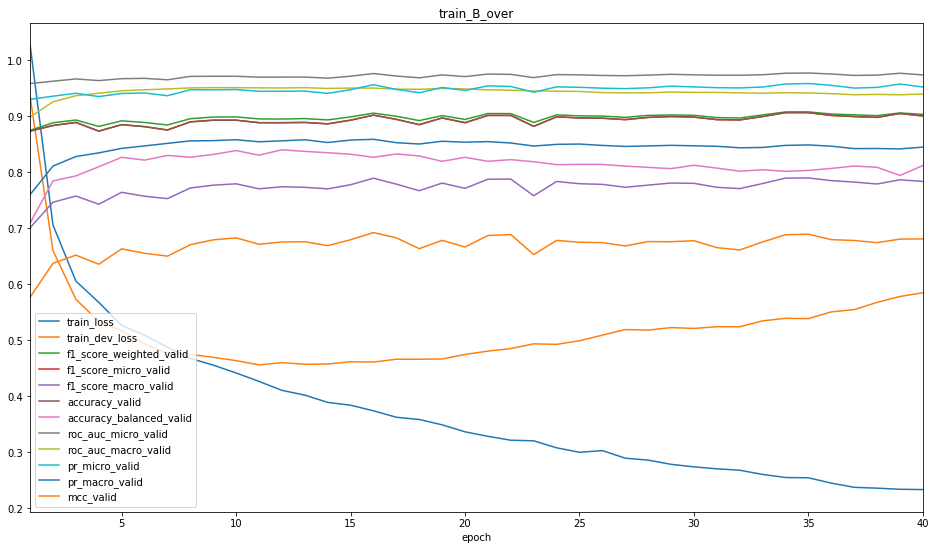

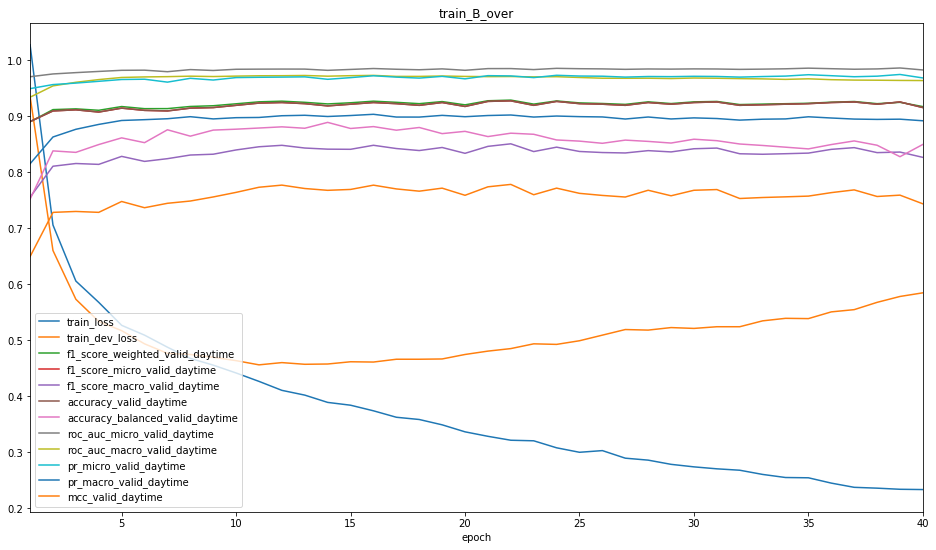

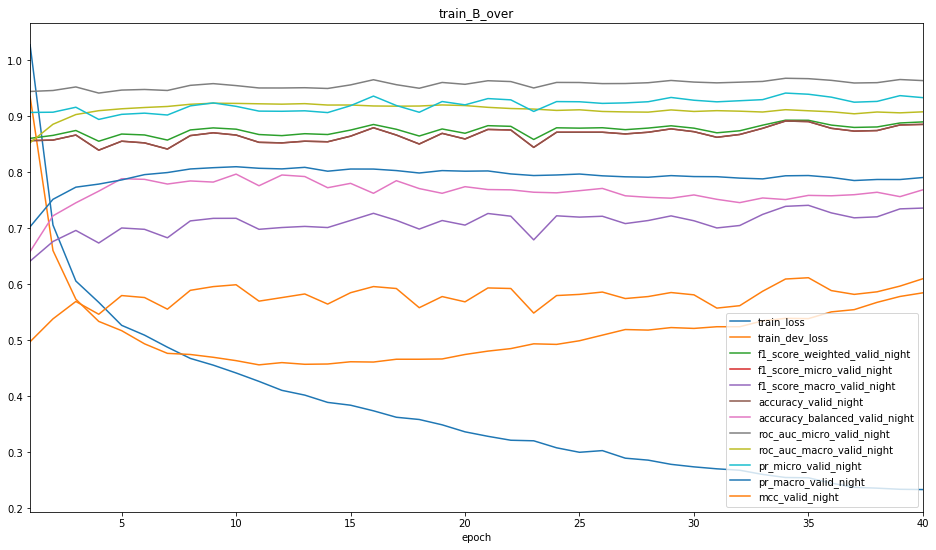

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)